In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset
from hmpai.data import SAT1_STAGES_ACCURACY, COMMON_STAGES, SAT_CLASSES_ACCURACY
from hmpai.visualization import plot_confusion_matrix, plot_predictions_on_epoch
from hmpai.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from mne.io import read_info
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import pandas as pd
from hmpai.behaviour.sat2 import read_behavioural_info
DATA_PATH = Path(os.getenv("DATA_PATH"))

### Load data

In [2]:
torch.cuda.empty_cache()
torch.set_grad_enabled(False)

In [3]:
set_global_seed(42)
data_path_sat2 = DATA_PATH / "sat2/stage_data_100hz.nc"
dataset_sat2 = xr.load_dataset(data_path_sat2)
behaviour_sat2 = read_behavioural_info(DATA_PATH / "sat2/behavioural/df_full.csv")

In [3]:
dataset_sat2

<xarray.Dataset> Size: 3GB
Dimensions:      (epochs: 2447, channels: 30, samples: 250, participant: 18)
Coordinates:
  * epochs       (epochs) int64 20kB 0 1 2 3 4 5 ... 2442 2443 2444 2445 2446
  * channels     (channels) <U3 360B 'Fp1' 'Fp2' 'AFz' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 2kB 0 1 2 3 4 5 6 ... 244 245 246 247 248 249
  * participant  (participant) <U3 216B 'S10' 'S11' 'S12' ... 'S7' 'S8' 'S9'
    event_name   (participant, epochs) <U21 4MB 'low/accuracy/right/3' ... 'a...
    rt           (participant, epochs) float64 352kB 0.7334 0.5977 ... 1.014
Data variables:
    data         (participant, epochs, channels, samples) float64 3GB 1.256e-...
    labels       (participant, epochs, samples) <U13 573MB 'pre-attentive' .....
Attributes:
    sfreq:           102.4
    offset:          0
    lowpass:         33.03225806451613
    highpass:        1.0
    lower_limit_RT:  0.25
    upper_limit_RT:  2.5

In [4]:
# XArray dimensions to keep in batching (used to find which trial was used)
info_to_keep = ["rt", "participant", "epochs"]
# Does not remove epochs since sp/ac epoch differ per participant so no epoch is fully sp/ac
shape_topological = False
_, _, test_data_sat2 = split_data_on_participants(dataset_sat2, 60, norm_min1_to_1)
test_data_sat2_sp = test_data_sat2.where(
    test_data_sat2.event_name.str.contains("speed"), drop=True
)
test_data_sat2_acc = test_data_sat2.where(
    test_data_sat2.event_name.str.contains("accuracy"), drop=True
)

test_dataset_sp = SAT1Dataset(
    test_data_sat2_sp,
    shape_topological=shape_topological,
    labels=SAT_CLASSES_ACCURACY,
    set_to_zero=True,
    info_to_keep=info_to_keep,
)
test_dataset_acc = SAT1Dataset(
    test_data_sat2_acc,
    shape_topological=shape_topological,
    labels=SAT_CLASSES_ACCURACY,
    set_to_zero=True,
    info_to_keep=info_to_keep,
)

test_loader_sp = DataLoader(
    test_dataset_sp, batch_size=128, shuffle=False, num_workers=0, pin_memory=True
)
test_loader_acc = DataLoader(
    test_dataset_acc, batch_size=128, shuffle=False, num_workers=0, pin_memory=True
)

### Load model

In [5]:
chk_path = Path("../models/sat2_transformer_100hz_sequence_b2b.pt")
checkpoint = load_model(chk_path)
model_kwargs = {
    "d_model": len(test_data_sat2.channels),
    "num_heads": 10,
    "ff_dim": 2048,
    "num_layers": 6,
    "num_classes": len(SAT_CLASSES_ACCURACY),
}
model = Seq2SeqTransformer(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Apply model

In [16]:
data_list = []
for batch in test_loader_sp:
    data = {
        'rt': batch[2]['rt'],
        'participant': batch[2]['participant'],
        'epochs': batch[2]['epochs'],
    }
    pred = model(batch[0].to(DEVICE))
    pred = torch.nn.Softmax(dim=2)(pred)
    pred = pred.cpu().detach()
    batch_aucs = torch.sum(pred, dim=1)

    for i, label in enumerate(SAT_CLASSES_ACCURACY):
        data[label + '_auc'] = batch_aucs[:,i]
    data_list.append(pd.DataFrame(data))
data_sp = pd.concat(data_list)
data_sp = data_sp.merge(behaviour_sat2, left_on=['participant','epochs'], right_on=['participant', 'trial'])
torch.cuda.empty_cache()
data_list = []
for batch in test_loader_acc:
    data = {
        'rt': batch[2]['rt'],
        'participant': batch[2]['participant'],
        'epochs': batch[2]['epochs'],
    }
    pred = model(batch[0].to(DEVICE))
    pred = torch.nn.Softmax(dim=2)(pred)
    pred = pred.cpu().detach()
    batch_aucs = torch.sum(pred, dim=1)

    for i, label in enumerate(SAT_CLASSES_ACCURACY):
        data[label + '_auc'] = batch_aucs[:,i]
    data_list.append(pd.DataFrame(data))
data_acc = pd.concat(data_list)
data_acc = data_acc.merge(behaviour_sat2, left_on=['participant','epochs'], right_on=['participant', 'trial'])

data = pd.concat([data_sp, data_acc])
data["ratio"] = (data["confirmation_auc"] / 100) / data["rt_x"]
torch.cuda.empty_cache()

### Plot results

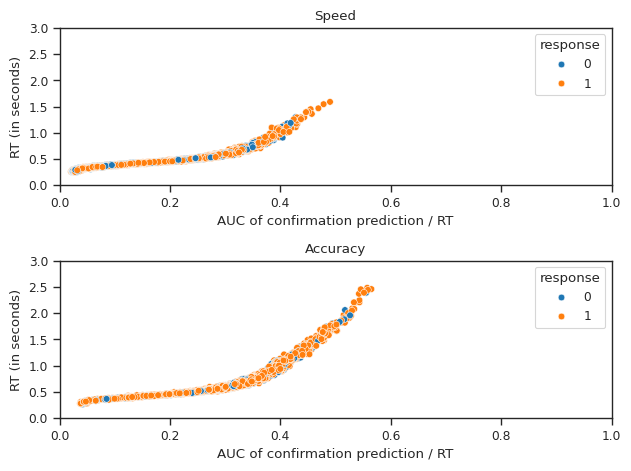

In [7]:
# Confirmation
plt.rcParams["figure.autolayout"] = True
sns.set_style("ticks")
sns.set_context("paper")
sns.set_palette("tab10")
fig, ax = plt.subplots(2, 1)
ax[0].title.set_text("Speed")
sns.scatterplot(data[data['SAT'] == 'speed'], x="ratio", y="rt_x", ax=ax[0], hue='response')
ax[1].title.set_text("Accuracy")
sns.scatterplot(data[data['SAT'] == 'accuracy'], x="ratio", y="rt_x", ax=ax[1], hue='response')
plt.setp(
    ax,
    xlim=(0, 1.0),
    ylim=(0, 3),
    ylabel="RT (in seconds)",
    xlabel="AUC of confirmation prediction / RT",
)
plt.show()

<Axes: xlabel='SAT', ylabel='ratio'>

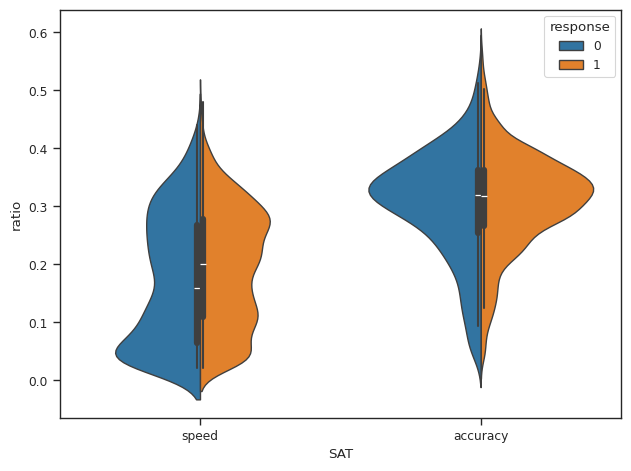

In [31]:
sns.violinplot(x='SAT', y='ratio', data=data, split=True, hue='response')

In [17]:
bins = np.linspace(0, 1, 11)
data['ratio_bin'] = pd.cut(data['ratio'], bins, include_lowest=True)


In [32]:
data_sp = data[data['SAT'] == 'speed']
data_acc = data[data['SAT'] == 'accuracy']

In [63]:
crosstab_sp = pd.crosstab(data_sp['ratio_bin'], data_sp['response'], normalize='index')
crosstab_acc = pd.crosstab(data_acc['ratio_bin'], data_acc['response'], normalize='index')

crosstab_sp['SAT'] = 'speed'
crosstab_acc['SAT'] = 'accuracy'
crosstab = pd.concat([crosstab_sp, crosstab_acc])
crosstab_long = crosstab.reset_index().melt(id_vars=['ratio_bin', 'SAT'], value_vars=[0, 1], var_name='response', value_name='proportion')

In [64]:
crosstab_long

,ratio_bin,SAT,response,proportion
0,"(-0.001, 0.1]",speed,0,0.355476
1,"(0.1, 0.2]",speed,0,0.219595
2,"(0.2, 0.3]",speed,0,0.196107
3,"(0.3, 0.4]",speed,0,0.248571
4,"(0.4, 0.5]",speed,0,0.300000
5,"(-0.001, 0.1]",accuracy,0,0.295455
6,"(0.1, 0.2]",accuracy,0,0.206395
7,"(0.2, 0.3]",accuracy,0,0.141556
8,"(0.3, 0.4]",accuracy,0,0.155936
9,"(0.4, 0.5]",accuracy,0,0.190594


<Axes: xlabel='ratio_bin', ylabel='proportion'>

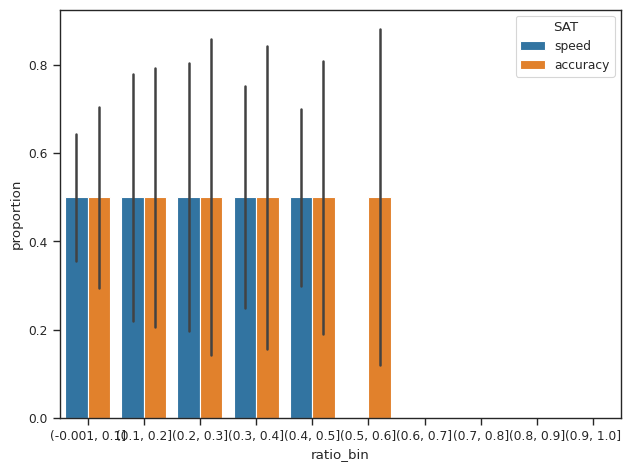

In [70]:
sns.barplot(x='ratio_bin', y='proportion', hue='SAT', data=crosstab_long)
